In [28]:
from enum import Enum
import math


import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager


from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


from funclib.iolib import folder_open
from funclib.baselib import pickle, unpickle
from funclib.numericslib import roundx
from dblib import mssql
from plotlib.mplfuncs import FigWidthsInch

In [2]:
#GET DATAFRAME FROM SQL

In [3]:
sql="select tl_mm, lens_subj_triangle_est, abs(rotation) as rotation ,accuracy ,hw_ratio, all_corr_rot_adj2_mm_error_perc as bias_percent, abs(all_corr_rot_adj2_mm_error_perc) as abs_bias_percent from v_mv_long_form where cnn = 'nas' and (transform like 'r%' or transform like 'none') and accuracy>0.5"

with mssql.Conn('imagedb', '(local)') as cnn:
    df_hwratio = pd.read_sql(sql, cnn)
list(df_hwratio)

['tl_mm',
 'lens_subj_triangle_est',
 'rotation',
 'accuracy',
 'hw_ratio',
 'bias_percent',
 'abs_bias_percent']

In [4]:
#FORMAT THE DATA FOR SKLEARN CONSUMPTION, DO SOME SETUP

In [5]:
rotation = np.array(df_hwratio.rotation)
accuracy = np.array(df_hwratio.accuracy)
hw_ratio = np.array(df_hwratio.hw_ratio)
bias_percent = np.array(df_hwratio.bias_percent)

hw_bias_acc = np.c_[hw_ratio, bias_percent, accuracy]
print(hw_bias_acc.shape)

(16508, 3)


In [6]:
#Split data into train and valuation

In [7]:
train, valuation = train_test_split(hw_bias_acc, train_size=0.7, shuffle=True)
print('train.shape: %s    valuation.shape: %s' % (train.shape, valuation.shape))

train.shape: (11555, 3)    valuation.shape: (4953, 3)


C:\Python354x64\Lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
#ISOLATION FOREST ON BIAS, HWRATIO and SCORE

In [13]:
outliers_fraction = 0.2
n_samples = train.shape[0]

clf = IsolationForest(max_samples=n_samples, contamination=outliers_fraction, random_state=np.random.RandomState(28)) #the classifier
clf.fit(train)
scores_pred = clf.decision_function(train) #vector of predictions scores(floats), low values are outliers
y_pred = clf.predict(train) #vector of -1 and 1, 1=Inlier, -1=outlier
threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)
print('Model Trained')

Model Trained


In [14]:
#PLOT IT

In [15]:
train_inlier = train[y_pred == 1]
train_outlier = train[y_pred == -1]

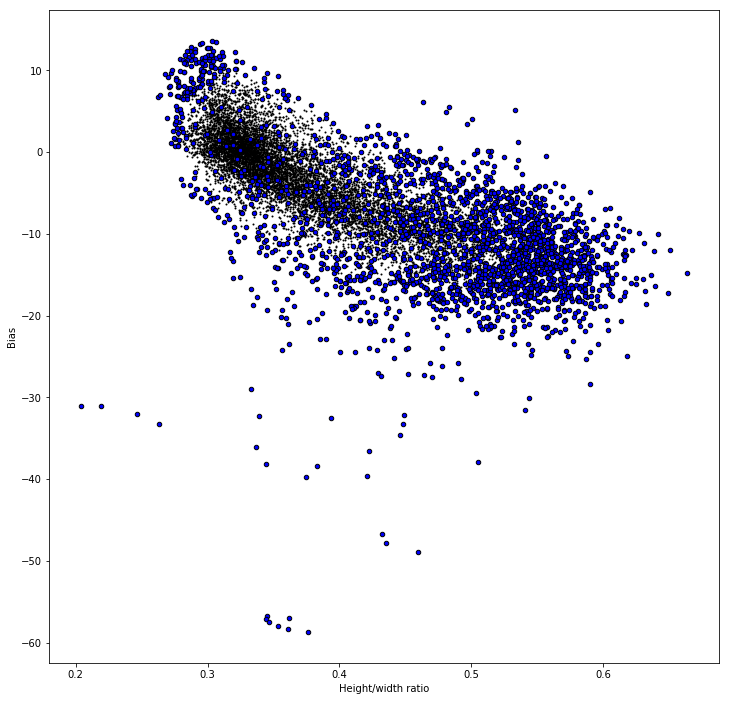

In [20]:
plt.close()
plt.figure(figsize=(12, 12))
ax = plt.gca()

ax_inlier = plt.scatter(train_inlier[:,0], train_inlier[:,1], c='white', s=1, edgecolor='k')
ax_outlier = plt.scatter(train_outlier[:,0], train_outlier[:,1], c='blue', s=20, edgecolor='k')
plt.axis('tight')
ax.set_xlabel('Height/width ratio')
ax.set_ylabel('Bias')
#plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/hw_outliers.svg', dpi=500)
#plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/hw_outliers.jpg')
#folder_open('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images')
plt.show()

In [65]:
#NOW FIT THE OTHER STUFF

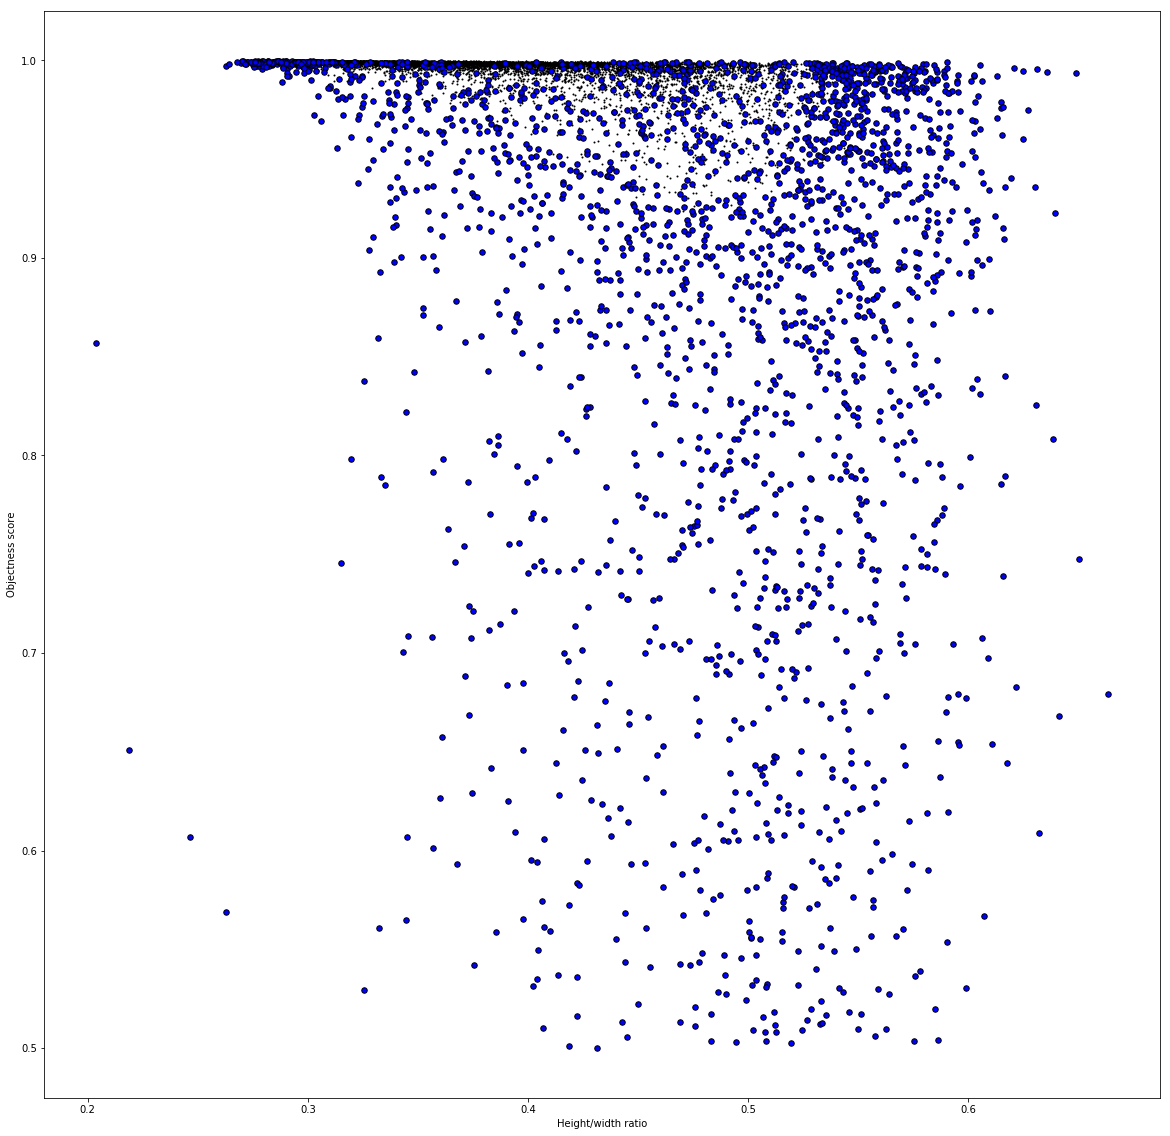

In [18]:
plt.close()
plt.figure(figsize=(20, 20))
ax = plt.gca()
ax.set_xlabel('Height/width ratio')
ax.set_ylabel('Objectness score')
ax_in = plt.scatter(train_inlier[:,0], train_inlier[:,2], c='white', s=1, edgecolor='k')
ax_out = plt.scatter(train_outlier[:,0], train_outlier[:,2], c='blue', s=30, edgecolor='k')


In [ ]:
#NOW USE THE INLIERS TO TRAIN A PREDICTIVE MODEL BIAS%~HW + ACCURACY

In [26]:
np.random.seed(np.random.randint(1,100))
trainX = np.c_[train_inlier[:,0], train_inlier[:,2]]
trainY = train_inlier[:,1]




In [ ]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True)
gp.fit(trainX, trainY)
print('Done')



In [ ]:
#SAVE GPR
pickle(gp, 'C:/development/python/jupyter/mv_sklearn_forest_outliers/gaussianprocess.pkl')
print('Model saved to 'C:/development/python/jupyter/mv_sklearn_forest_outliers/gaussianprocess.pkl')

In [87]:
#Create the outlier model without known bias so
#we can filter out outliers in evaluation data
#THIS WILL BE USED TO PREFILTER OUTLIERS FROM THE VALUATION DATASET

In [82]:
#x_inlier = X[y_pred == 1]
filtered_hw_acc = np.c_[train_inlier[:,0], train_inlier[:,2]]

clfValuation = IsolationForest(max_samples=filtered_hw_acc.shape[0], contamination=0, random_state=rng) #the classifier
clfValuation.fit(filtered_hw_acc)
scores_pred = clf.decision_function(filtered_hw_acc)
y_pred = clfValuation.predict(filtered_hw_acc)

pickle(clfValuation, 'C:/development/python/jupyter/mv_sklearn_forest_outliers/eval_outlier_model.pkl')
print('Model saved to C:/development/python/jupyter/mv_sklearn_forest_outliers/eval_outlier_model.pkl')

Done


In [ ]:
#TEST THE OUTLIER MODEL
outlier = np.array([[0.4, 0.5]])
outlier.shape
clf.predict(outlier)

outlier = np.array([[0.3, 0.999999]])
outlier.shape
clf.predict(outlier)

In [ ]:
#VALUATION DATA - FILTER OUTLIERS
#Load pickle
clfValuation = unpickle('C:/development/python/jupyter/mv_sklearn_forest_outliers/eval_outlier_model.pkl')
val_pred = clfValuation.predict(valuation)
valuation_inlier = valuation[val_pred == 1]
valuation_outlier = valuation[val_pred == -1]

In [ ]:
#VALUATION DATA - CORRECT TL ESTIMATE USING MODEL
#TODO

In [ ]:
#Load GP Model
gp = unpickle('C:/development/python/jupyter/mv_sklearn_forest_outliers/gaussianprocess.pkl')
val_adj = gp.predict(valuation_inlier) #THIS SHOULD CONTAIN ARE PERCENT ADJUSTMENTS